# Generar la curva monótona de caudales (caudales clasificados)

Los registros de las estaciones de aforo ubicadas en varios puntos de la geografía española pueden conseguirse en la página web del [Ministerio de Agricultura y Medio Ambiente.](http:\\www.magrama.es)

- [Inventario de presas y embalses](http://sig.mapama.es/snczi/)

- [Información de aforos](https://sig.mapama.gob.es/redes-seguimiento/)

- [Datos de la Estación de Aforos de Carmona](https://sig.mapama.gob.es/93/ClienteWS/redes-seguimiento/default.aspx?origen=1008&nombre=ROEA_ESTACIONES_AFORO_RIOS&claves=COD_HIDRO%7CCOD_SITUACION_ESTACION&valores=5125%7C4)


Los datos vienen en formatos bastante difíciles de procesar de forma manual. En este *Notebook* vamos a ver cómo leer y procesar esos datos usando *Python* y un paquete llamado *Pandas*.

In [1]:
# para generar graficos en linea:
%pylab inline  

# Primero importamos los paquetes Pandas, Numpy, matplotlib y plotly:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

#import plotly.plotly as py

Populating the interactive namespace from numpy and matplotlib


## Lectura de datos desde un fichero de texto

En este caso el fichero a leer es un txt ubicado en la misma carpeta donde está este notebook.
Voy a usar la función `read_csv()` de *Pandas* para leer el fichero txt. Esta función tiene los siguientes atributos:

- `sep = '\s+'`: indica que los datos están separados por varios espacios en blanco.
- `skiprows`: indica las filas del fichero que se debe ignorar.
- `parse_dates = 1`: para indicar que la segunda columna contiene datos de tipo fecha (en python la primera es la 0).
- `index_col = 1`: para decir que use la segunda columna como índice de la tabla.
- `dayfirst = True`: para indicar que en el formato de fecha del fichero el día está en la primera posición (dd/mm/aaaa).

In [2]:
filetoread = 'est9120_09_11.txt'
datos = pd.read_csv(filetoread, sep='\s+', skiprows=[0,1,2,3,5], parse_dates=[1], index_col=1, dayfirst=True)
# pedimos que nos muestre hasta el tercer valor:
datos[:3] 

,Estac.,Altura(m),Caudal(m3/s)
Fecha,,,
2009-10-01,9120,0.50,21.48
2009-10-02,9120,0.52,23.34
2009-10-03,9120,0.52,23.41


Una vez que los datos han sido leídos por Pandas, pueden procesarse para extraer información útil:

In [3]:
print('En el fichero que estoy leyendo, el primer día es: \n{}'.format(datos.index[0]))
print ('y el último: \n{}'.format(datos.index[-1]))

#datos.ix['2010-10-01':'2010-10-30']

En el fichero que estoy leyendo, el primer día es: 
2009-10-01 00:00:00
y el último: 
2012-09-30 00:00:00


Por tanto, este fichero dispone de datos de tres años hidrológicos.

Cada columna se denomina 'Serie', similar hasta cierto punto a un vector de Matlab.

Por ejemplo, pueden hacerse búsquedas entre los datos de la serie: hallar los días en que la altura fue menor que 0.45 m

In [4]:
datos[datos['Altura(m)']<0.45]

,Estac.,Altura(m),Caudal(m3/s)
Fecha,,,
2011-08-06,9120,-100.00,-100.0
2011-08-07,9120,-100.00,-100.0
2012-08-29,9120,0.44,36.4
2012-09-23,9120,0.44,36.4
2012-09-24,9120,0.44,36.4
2012-09-25,9120,0.44,36.4
2012-09-26,9120,0.44,36.4
2012-09-27,9120,0.44,36.4
2012-09-28,9120,0.44,36.4


Caudal máximo, mínimo y medio de la serie temporal:

In [19]:
Qmax = max(datos['Caudal(m3/s)'])
Qmin = min(datos['Caudal(m3/s)'])
Qmean = mean(datos['Caudal(m3/s)'])
print(' Caudal máximo: {:1.2f} \n Caudal mínimo: {:1.2f} \n Caudal medio:{:1.2f}'.format(Qmax, Qmin, Qmean))

 Caudal máximo: 745.79 
 Caudal mínimo: 20.35 
 Caudal medio:75.96


## Filtrado de datos

Vamos a comprobar si hay datos que faltan en el fichero de origen. Según se indica en el propio fichero, los datos faltantes están indicados con el valor '-100'.

In [20]:
datos[datos['Caudal(m3/s)']<0]

,Estac.,Altura(m),Caudal(m3/s)
Fecha,,,


Dado que solo son dos días, vamos a reemplazar esos dos datos con los de los días anterior y posterior, respectivamente.

In [6]:
#datos.ix['2011-08-06']['Caudal(m3/s)']=0
#['Caudal(m3/s)']=datos['2011-08-05']['Caudal(m3/s)']
datos.loc['2011-08-06','Caudal(m3/s)'] = datos.loc['2011-08-05','Caudal(m3/s)']
datos.loc['2011-08-07','Caudal(m3/s)'] = datos.loc['2011-08-08','Caudal(m3/s)']

Se puede graficar la evolución del caudal durante los tres años hidrológicos. Para esto usamos un paquete denominado *Matplotlib* que permite hacer gráficas con una sintaxis similar a Matlab.

Text(0,0.5,'Caudal $m^3/s$')

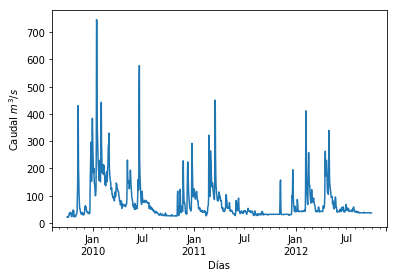

In [12]:
# Se obtiene la Serie 'Caudales' a partir de la tabla 'Datos'
caudales = datos['Caudal(m3/s)']

# Se genera el lienzo de dibujo y los ejes
fig, ax = plt.subplots()
caudales.plot()
ax.set_xlabel(u'Días')
ax.set_ylabel('Caudal $m^3/s$')
#py.iplot_mpl(fig)

Sin embargo, esta gráfica no nos proporciona información útil a la hora de determinar el caudal de equipamiento de nuestra central. Para esto es mucho más útil la curva de caudales clasificados anuales.

## Construcción de la curva de caudales clasificados

<div class="alert alert-info" style="font-size:120%">
    Como se dispone de tres años hidrológicos, vamos a empezar por <b>separar los datos por año</b>. Una vez hecho esto, vamos a <b>ordenar los datos de mayor a menor</b> para obtener la monotona de cada año. Por último, vamos a <b>calcular la media de los tres años</b>, curva que emplearemos para la determinación del caudal de equipamiento.
    
</div>

### Separar los datos por año hidrológico (1 Oct - 30 Sept):

La extensión `.loc[]` permite filtrar los datos de la tabla por el índice de la misma (en este caso las fechas)

In [25]:
year0910 = datos.loc['2009-10-01':'2010-09-30']
year1011 = datos.loc['2010-10-01':'2011-09-30']
year1112 = datos.loc['2011-10-01':'2012-09-30']
year1112.head()

,Estac.,Altura(m),Caudal(m3/s)
Fecha,,,
2011-10-01,9120,0.53,31.3
2011-10-02,9120,0.53,31.3
2011-10-03,9120,0.53,31.3
2011-10-04,9120,0.53,31.3
2011-10-05,9120,0.53,31.3


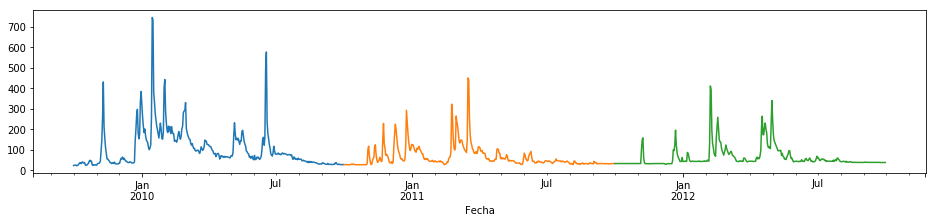

In [57]:
fig, ax = plt.subplots(figsize=(16,3))
year0910['Caudal(m3/s)'].plot(ax=ax, label='0910')
year1011['Caudal(m3/s)'].plot(ax=ax, label='1011')
year1112['Caudal(m3/s)'].plot(ax=ax, label='1112')


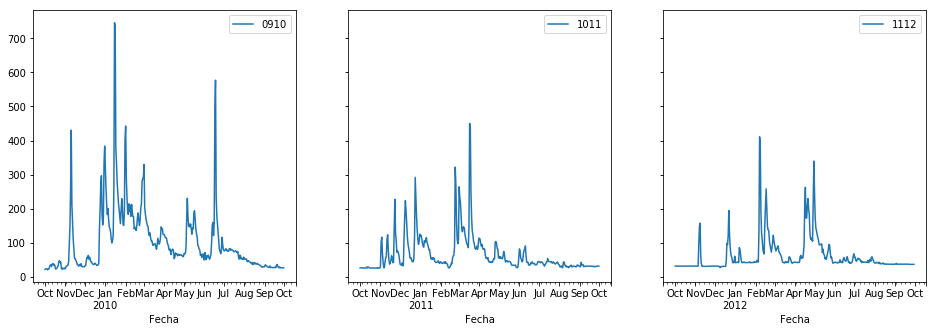

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16,5))
year0910['Caudal(m3/s)'].plot(ax=ax1, label='0910')
year1011['Caudal(m3/s)'].plot(ax=ax2, label='1011')
year1112['Caudal(m3/s)'].plot(ax=ax3, label='1112')
ax1.legend()
ax2.legend()
ax3.legend()

### Ordenar los datos de cada año de mayor a menor para obtener la monótona:

In [64]:
# Hay que ordenar los caudales de cada año en sentido decreciente:
orden0910 = year0910.sort_values(by='Caudal(m3/s)',ascending=False)['Caudal(m3/s)']
orden1011 = year1011.sort_values(by='Caudal(m3/s)',ascending=False)['Caudal(m3/s)']
orden1112 = year1112.sort_values(by='Caudal(m3/s)',ascending=False)['Caudal(m3/s)']
# Comprobamos
orden1112[0:10]

Fecha
2012-02-07    410.9
2012-02-08    390.4
2012-04-30    339.7
2012-04-17    262.8
2012-02-17    258.0
2012-05-01    246.9
2012-04-29    231.2
2012-04-21    229.5
2012-02-16    208.8
2012-04-20    208.3
Name: Caudal(m3/s), dtype: float64

In [71]:
year1 = np.asarray(orden0910)
year2 = np.asarray(orden1011)
year3 = np.asarray(orden1112)
print(type(year1))
year1[0:10]

<class 'numpy.ndarray'>


array([745.79, 734.62, 577.19, 493.35, 442.55, 430.51, 403.94, 383.62,
       377.62, 333.97])

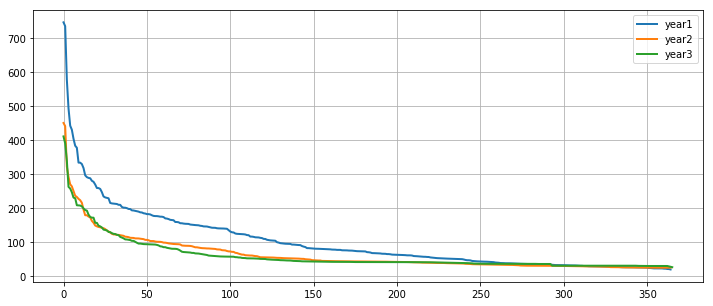

In [81]:
fig, ax = plt.subplots(figsize=(12,5))
p1 = ax.plot(year1, label='year1', lw=2)
p2 = ax.plot(year2, label='year2', lw=2)
p3 = ax.plot(year3, label='year3', lw=2)
ax.legend()
ax.grid()

### Calcular la monótona de caudal media

In [84]:
# Vector que contendrá la curva monótona de caudales medios:
year_mean = []
# cálculo de la curva clasificada media:
for el in range(len(year1)):
    year_mean.append((year1[el] + year2[el] + year3[el])/3)
# Comprobamos
    year_mean[0:10]

Finalmente, se pueden graficar las tres monótonas y la curva con los valores medios:

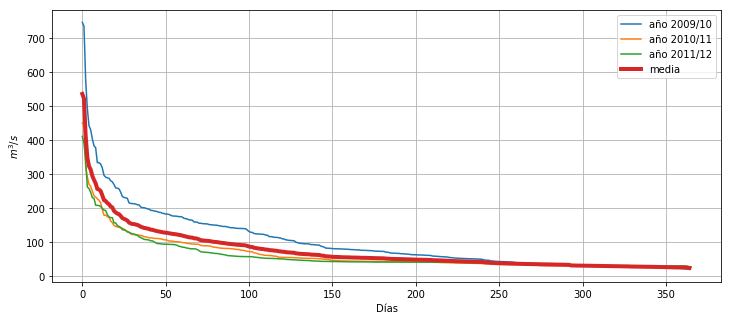

In [93]:
fig, ax = plt.subplots(figsize=(12,5))
p1 = ax.plot(year1, label=u'año 2009/10')
p2 = ax.plot(year2, label=u'año 2010/11')
p3 = ax.plot(year3, label=u'año 2011/12')
p4 = ax.plot(year_mean,lw=4,label=u'media')
ax.legend()
ax.set_xlabel(u'Días')
ax.set_ylabel(u'$m^3/s$')
ax.grid()

In [94]:
print("Caudal medio mínimo anual: {:.2f} m3/s".format(np.min(year_mean)))
print("Caudal medio máximo anual: {:.2f} m3/s".format(np.max(year_mean)))
print("Caudal medio medio anual: {:.2f} m3/s".format(np.mean(year_mean)))

Caudal medio mínimo anual: 24.72 m3/s
Caudal medio máximo anual: 535.67 m3/s
Caudal medio medio anual: 76.00 m3/s


Con la curva de caudales clasificados se pueden responder varias preguntas:

1. Caudal que se supera durante 100 días:

In [103]:
year_mean[100]

87.54333333333334

2. ¿Número de días en los que el caudal es mayor que 80 m3/s?

In [102]:
days_q_is_greater = [i for i,x in enumerate(year_mean) if x>=80]
max(days_q_is_greater)

108

## Adaptación para los nuevos formatos de datos

Para datos con el nuevo formato (por ejemplo 5125.xlsx) es mejor no separar la curva por años hidrológicos. Se tendrán en cuenta todos los datos y se uniformizará la escala del eje $x$ para obtener valores entre 0 y 1.

1. Convertir el fichero excel a csv (comma separated values)
2. Leer el fichero 5125.csv en pandas

In [63]:
# na_values='-' informa que los guiones son datos que faltan.
curva5125 = pd.read_csv('5125.csv', sep=',', na_values='-')

In [64]:
curva5125

,Estación,Año,Día,Oct,Nov,Dic,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep
0,5125,1945-1946,1,0.08,0.08,0.17,3.74,0.50,0.42,1.13,1.13,2.08,0.33,0.33,0.33
1,5125,1945-1946,2,0.08,0.08,0.17,7.70,0.50,5.40,1.13,3.24,2.08,0.33,0.33,0.33
2,5125,1945-1946,3,0.08,0.08,0.17,1.13,0.50,18.90,1.13,3.24,2.08,0.33,0.33,0.33
3,5125,1945-1946,4,0.08,0.08,0.17,0.50,0.50,3.24,2.08,3.95,2.08,0.33,0.33,0.33
4,5125,1945-1946,5,0.08,0.08,0.17,0.50,0.64,1.80,9.58,6.10,2.08,0.33,0.33,0.23
5,5125,1945-1946,6,0.08,0.08,0.17,4.55,0.64,20.80,3.24,14.75,2.08,0.33,0.33,0.33
6,5125,1945-1946,7,0.08,0.08,0.17,1.13,0.50,17.40,1.13,10.33,2.08,0.33,0.33,0.33
7,5125,1945-1946,8,0.08,0.00,0.17,0.64,0.42,6.10,1.13,12.95,2.08,0.33,0.33,0.33
8,5125,1945-1946,9,0.08,0.00,0.17,0.50,0.42,4.55,1.13,6.10,1.13,0.33,0.33,0.33
9,5125,1945-1946,10,0.08,0.00,0.17,0.50,0.42,2.08,1.13,17.10,1.13,0.33,0.33,0.33


1. Se forma un vector (`total`) con los datos de todas las columnas 

In [65]:
ene = np.asarray(curva5125['Ene'])
feb = np.asarray(curva5125['Feb'])
mar = np.asarray(curva5125['Mar'])
abr = np.asarray(curva5125['Abr'])
may = np.asarray(curva5125['May'])
jun = np.asarray(curva5125['Jun'])
jul = np.asarray(curva5125['Jul'])
ago = np.asarray(curva5125['Ago'])
sep = np.asarray(curva5125['Sep'])
oct_ = np.asarray(curva5125['Oct'])
nov = np.asarray(curva5125['Nov'])
dic = np.asarray(curva5125['Dic'])
total = np.concatenate([ene, feb, mar, abr, may, jun, jul, ago, sep, oct_, nov, dic])
# Cálculo de la dimensión del vector total
print("La dimensión del vector total es de {} valores".format(total.shape[0]))

La dimensión del vector total es de 11904 valores


2. Se descartan los datos no numéricos (`nan`)

In [66]:
total = total[~numpy.isnan(total)]
print("La dimensión del vector total es de {} valores".format(total.shape[0]))

La dimensión del vector total es de 10824 valores


3. Ordenar `total` de mayor a menor
    La función `sort` ordena por defecto de menor a mayor. Para cambiar el orden se usa la siguiente línea
     `total = total[::-1]`

In [71]:
total.sort()
total = total[::-1]
total

array([750.  , 480.  , 325.84, ...,   0.  ,   0.  ,   0.  ])

Vamos a visualizar la curva de caudales normalizados

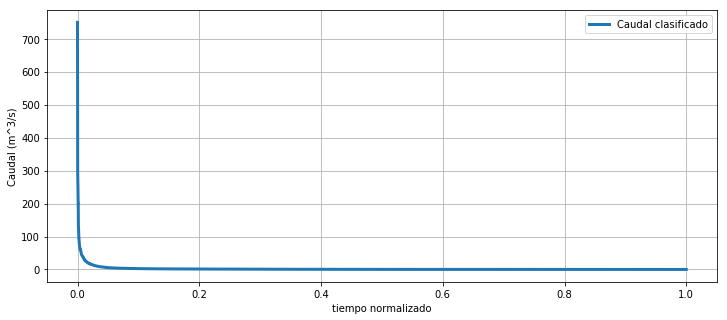

In [86]:
x = np.arange(0, 1, total.shape[0]**(-1))
fig, ax = plt.subplots(figsize=(12,5))
p1 = ax.plot(x,total, label='Caudal clasificado', lw=3, )
ax.legend()
ax.set_xlabel('tiempo normalizado')
ax.set_ylabel('Caudal (m^3/s)')
ax.grid()

Aparentemente es un río con un caudal muy estacional en el que no hay agua durante gran parte del año. En este caso la curva se visualiza mejor usando una escala logarítmica en el eje $y$:

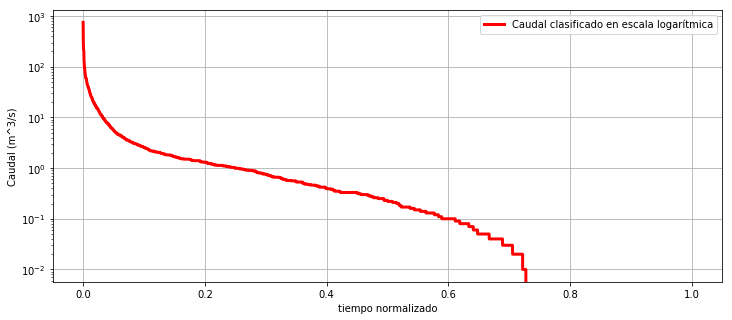

In [87]:
x = np.arange(0, 1, total.shape[0]**(-1))
fig, ax = plt.subplots(figsize=(12,5))
p1 = ax.semilogy(x,total, label='Caudal clasificado en escala logarítmica', lw=3, color='r' )
ax.legend()
ax.set_xlabel('tiempo normalizado')
ax.set_ylabel('Caudal (m^3/s)')
ax.grid()